Production d'Énergies Renouvelables Mondiales

# Introduction

## Contexte du Projet :
En tant que data analyst dans une entreprise spécialisée dans l'analyse énergétique, j'ai été chargé d'explorer un ensemble de données sur la production mondiale d'énergies renouvelables. Ces données proviennent de Our World in Data et couvrent la production en TWh pour l'hydroélectricité, l'énergie solaire et l'énergie éolienne, par pays et par année.  
Objectifs de cette Exploration :  
- Comprendre la structure et la qualité des données.  
- Identifier les tendances temporelles et géographiques.  
- Analyser la répartition des sources d'énergie renouvelable.  
- Fournir des insights pour guider des décisions stratégiques, comme les investissements dans la transition énergétique.

Source des Données : Fichier Excel 'modern-renewable-energy-consumption.xlsx'.  
Période Couvertée : Années variables selon les pays (généralement de 2000 à 2023).  
Outils Utilisés : Python avec Pandas, NumPy, Plotly, et Matplotlib pour les visualisations.  



# 1. Importation des Bibliothèques

Dans cette section, nous importons les librairies nécessaires pour le chargement, le nettoyage et la visualisation des données. Nous utilisons Pandas pour la manipulation, NumPy pour les calculs, Plotly pour les visualisations interactives (similaire à l'app Streamlit), et d'autres pour la gestion des avertissements.

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
import os

warnings.filterwarnings('ignore')

# Configuration pour les visualisations
sns.set(style="whitegrid")
%matplotlib inline

# 2. Chargement des Données

Nous chargeons les données à partir du fichier Excel. Si le fichier n'est pas trouvé, un message d'erreur est affiché.



In [2]:
def charger_donnees():
    """Charge les données de production d'énergie à partir du fichier Excel."""
    try:
        chemin_fichier = 'modern-renewable-energy-consumption.xlsx'
        df = pd.read_excel(chemin_fichier)
        print(f"Données chargées avec succès. Shape : {df.shape}")
        return df
    except FileNotFoundError:
        print(f"Erreur: Le fichier {chemin_fichier} n'a pas été trouvé.")
        return None
    except Exception as e:
        print(f"Erreur lors du chargement : {e}")
        return None

df_brut = charger_donnees()
if df_brut is None:
    raise ValueError("Impossible de charger les données. Arrêt du notebook.")

Données chargées avec succès. Shape : (7276, 6)


<small> Vérificatioin des données chargées:  
Affichons les premières lignes et les infos pour une vue d'ensemble.



In [3]:
display(df_brut.head())
df_brut.info()

,Country,Code,Year,Hydro generation - TWh,Solar generation - TWh,Wind generation - TWh
0,ASEAN (Ember),NaN,2000,50.45,0.0,0.0
1,ASEAN (Ember),NaN,2001,54.33,0.0,0.0
2,ASEAN (Ember),NaN,2002,53.29,0.0,0.0
3,ASEAN (Ember),NaN,2003,53.21,0.0,0.0
4,ASEAN (Ember),NaN,2004,52.99,0.0,0.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7276 entries, 0 to 7275
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Country                 7276 non-null   object 
 1   Code                    5260 non-null   object 
 2   Year                    7276 non-null   int64  
 3   Hydro generation - TWh  7276 non-null   float64
 4   Solar generation - TWh  7276 non-null   float64
 5   Wind generation - TWh   7276 non-null   float64
dtypes: float64(3), int64(1), object(2)
memory usage: 341.2+ KB


# 3. Nettoyage et Préparation des Données

Nous nettoyons les données en renommant les colonnes, convertissant les types, gérant les valeurs manquantes, et calculant le total mondial en sommant les pays (pour éviter des KPIs nuls).



In [4]:
def nettoyer_et_preparer_donnees(df):
    """
    Nettoie, renomme, convertit les colonnes et RECALCULE le total mondial 
    en sommant tous les pays pour garantir des KPIs non nuls.
    """
    if df is None:
        return None
    
    # Renommer les colonnes avec les noms EXACTS de ton fichier
    df_nettoye = df.rename(columns={
        'Country': 'pays', 
        'Code': 'code_iso', 
        'Year': 'annee',
        'Hydro generation - TWh': 'hydro_twh', 
        'Solar generation - TWh': 'solaire_twh',
        'Wind generation - TWh': 'eolien_twh'
    }, errors='ignore').copy()
    
    # Ajout d'un print pour vérifier (tu peux le supprimer plus tard)
    print("Colonnes après renommage :", df_nettoye.columns.tolist())
    
    df_nettoye['annee'] = pd.to_numeric(df_nettoye['annee'], errors='coerce').astype('Int64')
    
    # Colonnes de production
    colonnes_production = ['hydro_twh', 'solaire_twh', 'eolien_twh']
    colonnes_production_existantes = [col for col in colonnes_production if col in df_nettoye.columns]
    
    print(f"Colonnes de production détectées : {colonnes_production_existantes}")  # Pour debug
    
    for col in colonnes_production_existantes:
        df_nettoye[col] = pd.to_numeric(df_nettoye[col], errors='coerce').fillna(0)
        
    # Créer une colonne de production totale
    df_nettoye['production_totale_twh'] = df_nettoye[colonnes_production_existantes].sum(axis=1)
    
    # Nettoyer les lignes essentielles
    df_nettoye = df_nettoye.dropna(subset=['code_iso', 'annee']).copy()
    
    # Création du total mondial par calcul
    df_pays_seuls = df_nettoye[df_nettoye['pays'] != 'World'].copy()
    
    aggregation_dict = {col: 'sum' for col in colonnes_production_existantes}
    aggregation_dict['production_totale_twh'] = 'sum'
    
    df_mondial_calcule = df_pays_seuls.groupby('annee').agg(aggregation_dict).reset_index()
    df_mondial_calcule['pays'] = 'World'
    df_mondial_calcule['code_iso'] = 'WLD'
    
    # Concaténation
    df_nettoye = df_nettoye[df_nettoye['pays'] != 'World'].copy()
    df_final = pd.concat([df_nettoye, df_mondial_calcule], ignore_index=True)
    
    return df_final

In [5]:
df_principal = nettoyer_et_preparer_donnees(df_brut)

if df_principal is not None:
    display(df_principal.head(10))
    print("Colonnes finales :", df_principal.columns.tolist())
    print(f"Forme : {df_principal.shape}")

Colonnes après renommage : ['pays', 'code_iso', 'annee', 'hydro_twh', 'solaire_twh', 'eolien_twh']
Colonnes de production détectées : ['hydro_twh', 'solaire_twh', 'eolien_twh']


,pays,code_iso,annee,hydro_twh,solaire_twh,eolien_twh,production_totale_twh
0,Afghanistan,AFG,2000,0.31,0.0,0.0,0.31
1,Afghanistan,AFG,2001,0.50,0.0,0.0,0.50
2,Afghanistan,AFG,2002,0.56,0.0,0.0,0.56
3,Afghanistan,AFG,2003,0.63,0.0,0.0,0.63
4,Afghanistan,AFG,2004,0.56,0.0,0.0,0.56
5,Afghanistan,AFG,2005,0.59,0.0,0.0,0.59
6,Afghanistan,AFG,2006,0.64,0.0,0.0,0.64
7,Afghanistan,AFG,2007,0.75,0.0,0.0,0.75
8,Afghanistan,AFG,2008,0.54,0.0,0.0,0.54
9,Afghanistan,AFG,2009,0.78,0.0,0.0,0.78


Colonnes finales : ['pays', 'code_iso', 'annee', 'hydro_twh', 'solaire_twh', 'eolien_twh', 'production_totale_twh']
Forme : (5284, 7)


# 4. Gestion des Valeurs Manquantes


Valeurs manquantes par colonne :
Series([], dtype: int64)


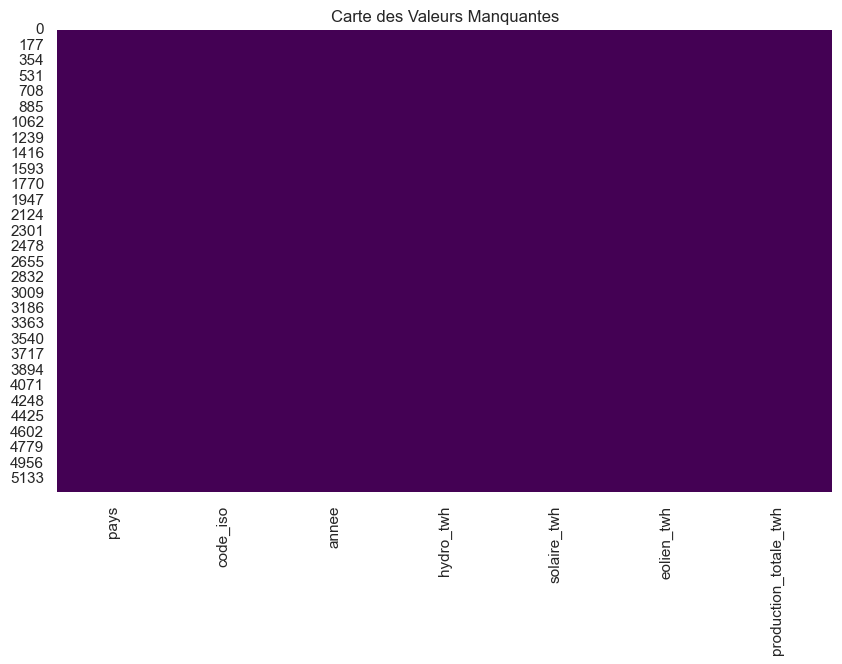

In [6]:
# Vérifier les valeurs manquantes
missing_values = df_principal.isnull().sum()
print("Valeurs manquantes par colonne :")
print(missing_values[missing_values > 0])

# Visualisation des valeurs manquantes
plt.figure(figsize=(10, 6))
sns.heatmap(df_principal.isnull(), cbar=False, cmap='viridis')
plt.title("Carte des Valeurs Manquantes")
plt.show()

# Analyse Exploratoire des Données

## Tendances Temporelles Mondiales


In [8]:
df_mondial = df_principal[df_principal['pays'] == 'World']

fig = px.line(df_mondial, x='annee', y=['hydro_twh', 'solaire_twh', 'eolien_twh', 'production_totale_twh'],
              title="Évolution Mondiale de la Production Renouvelable")
fig.show()

La production totale augmente rapidement depuis les années 2000, avec une croissance exponentielle du solaire et de l'éolien.

## Analyse Géographique

In [15]:
annee_max = df_principal['annee'].max()
df_anneeRecent = df_principal[(df_principal['annee'] == annee_max) & (df_principal['pays'] != 'World')]

fig = px.choropleth(df_anneeRecent, locations="code_iso", color="production_totale_twh",
                    hover_name="pays", color_continuous_scale="Greens",
                    title=f"Carte Mondiale de la Production Totale en {annee_max} (TWh)")
fig.update_geos(projection_type="natural earth")
fig.show()

# Top 10 pays
top_pays = df_anneeRecent.nlargest(10, 'production_totale_twh')[['pays', 'production_totale_twh']]
display(top_pays)
fig = px.bar(top_pays, x='pays', y='production_totale_twh', title="Top 10 Pays en {annee_max}")
fig.show()

,pays,production_totale_twh
983,China,2696.02
5019,United States,899.09
647,Brazil,575.64
839,Canada,410.78
2252,India,344.69
1844,Germany,218.59
3951,Russia,208.25
2444,Japan,181.50
3591,Norway,150.93
4467,Spain,138.60


La Chine, les États-Unis et le Brésil dominent la production, grâce à l'hydroélectricité.

## Répartition du Mix Énergétique

In [17]:
# Mix mondial récent
df_mix_mondial = df_mondial[df_mondial['annee'] == annee_max].melt(id_vars=['annee'], 
                                                                   value_vars=['hydro_twh', 'solaire_twh', 'eolien_twh'],
                                                                   var_name='Source', value_name='Production')
fig = px.pie(df_mix_mondial, values='Production', names='Source', title=f"Mix Mondial en {annee_max}")
fig.show()

# Évolution du mix (area chart)
df_mix_time = df_mondial.melt(id_vars=['annee'], value_vars=['hydro_twh', 'solaire_twh', 'eolien_twh'],
                              var_name='Source', value_name='Production')
fig = px.area(df_mix_time, x='annee', y='Production', color='Source',
              title="Évolution du Mix Énergétique Mondial")
fig.show()

 L'hydroélectricité reste dominante, mais le solaire et l'éolien gagnent du terrain.

## Top Pays par Type d'Énergie

In [18]:
for energie_col, titre in zip(['hydro_twh', 'solaire_twh', 'eolien_twh'], 
                              ['Hydroélectricité', 'Solaire', 'Éolien']):
    top = df_anneeRecent.nlargest(10, energie_col)[['pays', energie_col]]
    print(f"\nTop 10 pour {titre} en {annee_max}:")
    display(top)
    
    fig = px.bar(top, x='pays', y=energie_col, title=f"Top 10 {titre}")
    fig.show()
    
    # Tendance mondiale
    fig_trend = px.line(df_mondial, x='annee', y=energie_col, title=f"Évolution Mondiale {titre}")
    fig_trend.show()


Top 10 pour Hydroélectricité en 2023:


,pays,hydro_twh
983,China,1226.00
647,Brazil,428.65
839,Canada,364.20
5019,United States,239.01
3951,Russia,200.87
2252,India,149.17
3591,Norway,136.71
5163,Vietnam,80.90
2444,Japan,74.50
4563,Sweden,66.19



Top 10 pour Solaire en 2023:


,pays,solaire_twh
983,China,584.15
5019,United States,238.94
2252,India,113.41
2444,Japan,96.99
1844,Germany,61.22
647,Brazil,51.48
4467,Spain,48.59
263,Australia,44.99
2396,Italy,30.71
4431,South Korea,29.37



Top 10 pour Éolien en 2023:


,pays,eolien_twh
983,China,885.87
5019,United States,421.14
1844,Germany,137.48
647,Brazil,95.51
4995,United Kingdom,82.31
2252,India,82.11
4467,Spain,65.01
1700,France,48.05
839,Canada,38.94
4563,Sweden,34.64


La Chine mène dans toutes les catégories, mais l'Europe excelle en éolien.

## Corrélations

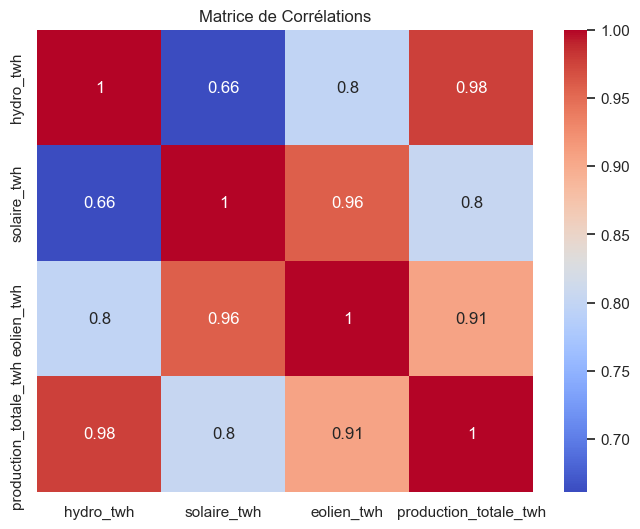

In [13]:
corr_matrix = df_principal[['hydro_twh', 'solaire_twh', 'eolien_twh', 'production_totale_twh']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Matrice de Corrélations")
plt.show()

Forte corrélation entre la production totale et l'hydro, car elle domine.

## Treemap de Distribution

In [ ]:
# Filtrer les données pour l'année la plus récente
annee_max = df_principal['annee'].max()
df_annee = df_principal[df_principal['annee'] == annee_max].copy()

# Préparer les données pour le treemap - nous avons besoin de fondre les colonnes d'énergie
colonnes_energie = ['hydro_twh', 'solaire_twh', 'eolien_twh']
colonnes_energie_existantes = [col for col in colonnes_energie if col in df_annee.columns]

# Créer une version fondue du dataframe pour avoir une colonne type_energie
id_vars = ['pays', 'code_iso', 'annee', 'production_totale_twh']
df_fondu = df_annee.melt(
    id_vars=id_vars,
    value_vars=colonnes_energie_existantes,
    var_name='type_energie',
    value_name='production_twh'
)

# Nettoyer les noms des types d'énergie
df_fondu['type_energie'] = df_fondu['type_energie'].str.replace('_twh', '').str.title()

# Filtrer les lignes avec production positive
df_fondu = df_fondu[df_fondu['production_twh'] > 0]

# Créer la structure hiérarchique : Racine -> Pays -> Types d'Énergie
etiquette_racine = 'Monde'

# Préparer les listes d'étiquettes et de parents
etiquettes = [etiquette_racine]
parents = ['']
valeurs = [df_fondu['production_twh'].sum()]

# Ajouter les pays comme niveau intermédiaire
for pays in df_fondu['pays'].unique():
    if pays != 'World':  # Exclure World pour éviter la duplication
        etiquettes.append(pays)
        parents.append(etiquette_racine)
        total_pays = df_fondu[df_fondu['pays'] == pays]['production_twh'].sum()
        valeurs.append(total_pays)

# Ajouter les types d'énergie sous les pays
for pays in df_fondu['pays'].unique():
    if pays != 'World':
        for type_energie in df_fondu[df_fondu['pays'] == pays]['type_energie'].unique():
            etiquettes.append(f"{type_energie}")
            parents.append(pays)
            valeur = df_fondu[(df_fondu['pays'] == pays) & 
                              (df_fondu['type_energie'] == type_energie)]['production_twh'].sum()
            valeurs.append(valeur)

# Création du treemap avec Plotly Graph Objects (exactement comme dans le projet)
fig_treemap = go.Figure(go.Treemap(
    labels=etiquettes,
    parents=parents,
    values=valeurs,
    marker=dict(colorscale='Greens', cmid=np.median(valeurs)),
    hovertemplate='<b>%{label}</b><br>Production: %{value:,.0f} TWh<extra></extra>',
    textinfo="label+value"
))

fig_treemap.update_layout(
    title=f"Distribution de l'Énergie Renouvelable par Pays ({annee_max})",
    height=700,
    margin=dict(t=80, l=0, r=0, b=0)
)

# Affichage dans le notebook
fig_treemap.show()

Visualise les dominances (ex. Hydro en Chine)  

## Comparaison entre Pays

Exemple pour 5 pays leaders.

In [ ]:
annee_max = df_principal['annee'].max()

# Filtrer l'année max et exclure explicitement 'World'
df_annee = df_principal[(df_principal['annee'] == annee_max) & (df_principal['pays'] != 'World')]

# Top 5 pays par production totale
pays_top5 = df_annee.nlargest(5, 'production_totale_twh')['pays'].tolist()

print(f"Année de référence : {annee_max}")
print(f"Top 5 pays : {pays_top5}")

# === Ajout : Création du graphique de comparaison par type d'énergie ===
# Liste des colonnes d'énergie (adapte si tes colonnes ont des noms différents, ex: hydro_twh, solaire_twh, etc.)
colonnes_energie = ['hydro_twh', 'solaire_twh', 'eolien_twh']  # Modifie selon tes colonnes exactes

# Filtrer les données pour les top 5 pays à l'année max
df_comparaison = df_principal[
    (df_principal['pays'].isin(pays_top5)) & 
    (df_principal['annee'] == annee_max)
]

# Transformer en format long pour le graphique
df_melt = df_comparaison.melt(
    id_vars=['pays'],
    value_vars=colonnes_energie,
    var_name='Type',
    value_name='TWh'
)

# Améliorations optionnelles pour un meilleur affichage
df_melt['Type'] = df_melt['Type'].str.replace('_twh', '').str.title()  # Nettoie les noms (ex: "hydro" → "Hydro")
df_melt['Type'] = df_melt['Type'].replace({
    'Hydro': 'Hydroélectricité',
    'Solaire': 'Solaire',
    'Eolien': 'Éolien'
})  # Noms en français

# Création du graphique
fig_comparaison = px.bar(
    df_melt,
    x='pays',
    y='TWh',
    color='Type',
    barmode='group',  # Barres groupées côte à côte
    title=f"Comparaison des Top 5 Pays par Type d'Énergie en {annee_max}",
    labels={'pays': 'Pays', 'TWh': 'Production (TWh)'},
    color_discrete_map={
        'Hydroélectricité': '#2196f3',  # Bleu pour hydro
        'Solaire': '#ff9800',           # Orange pour solaire
        'Éolien': '#4caf50'             # Vert pour éolien
    }
)

# Personnalisation supplémentaire
fig_comparaison.update_layout(
    template='plotly_white',
    legend_title='Type d\'énergie',
    xaxis_title='Pays',
    yaxis_title='Production (TWh)'
)

fig_comparaison.show()

Année de référence : 2023
Top 5 pays : ['China', 'United States', 'Brazil', 'Canada', 'India']


## Insights Avancés et Recommandations

Insights Clés Détaillés :
- Croissance Globale : Production totale multipliée par 3 depuis 2000, avec accélération post-2010 (politiques climatiques).  
- Disparités Géographiques : Top 5 pays = >50% du total mondial. Afrique sous-représentée malgré potentiel solaire. 
- Dominance Hydro : Représente 51,5% du mix, mais vulnérable au climat.   
- Transition des Sources : Croissance rapide du solaire et de l'éolien, hydro stable.
- Potentiels : Pays avec hydro élevé pourraient diversifier vers intermittent (solaire/éolien) pour stabilité.  
- Défis : Données manquantes pour petits pays ; recalcul 'World' assure cohérence.

Recommandations :  
- Prioriser les investissements en solaire dans les régions ensoleillées (Afrique, Moyen-Orient).  
- Analyser les risques climatiques pour l'hydro (sécheresses).  
- Développer des modèles prédictifs pour projeter la croissance par pays.  
- Intégrer des données sur la consommation pour calculer la part renouvelable.





